In [1]:
"""
Дан кварцевый аксиально-симметричный световод с ступенчатым профилем показателя
преломления (диаметр жилы 8.4 мкм, Δn=5.5∗10−3). Найти в приближении LP мод поперечные
моды такого световода на 532 нм, 1030 нм и 1550 нм. Какова длина волны отсечки такого
световода? Определите длину волны, на которой появляется мода LP21.
"""

'\nДан кварцевый аксиально-симметричный световод с ступенчатым профилем показателя\nпреломления (диаметр жилы 8.4 мкм, Δn=5.5∗10−3). Найти в приближении LP мод поперечные\nмоды такого световода на 532 нм, 1030 нм и 1550 нм. Какова длина волны отсечки такого\nсветовода? Определите длину волны, на которой появляется мода LP21.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, kv
from scipy.optimize import root_scalar
from numpy import pi
import math
import warnings
from typing import Callable, Iterable
import matplotlib.colors as colors
import pandas as pd

In [3]:
def multi_root(f: Callable, bracket: Iterable[float], args: Iterable = (), n: int = 1000) -> np.ndarray:
    """ Find all roots of f in `bracket`, given that resolution `n` covers the sign change.
    Fine-grained root finding is performed with `scipy.optimize.root_scalar`.
    Parameters
    ----------
    f: Callable
        Function to be evaluated
    bracket: Sequence of two floats
        Specifies interval within which roots are searched.
    args: Iterable, optional
        Iterable passed to `f` for evaluation
    n: int
        Number of points sampled equidistantly from bracket to evaluate `f`.
        Resolution has to be high enough to cover sign changes of all roots but not finer than that.
        Actual roots are found using `scipy.optimize.root_scalar`.
    Returns
    -------
    roots: np.ndarray
        Array containing all unique roots that were found in `bracket`.
    """
    # Evaluate function in given bracket
    x = np.linspace(*bracket, n)
    y = f(x, *args)

    # Find where adjacent signs are not equal
    sign_changes = np.where(np.sign(y[:-1]) != np.sign(y[1:]))[0]
    # print("\n----idx of sections where sign changes in multi_root", sign_changes, '\n')
    # Find roots around sign changes
    root_finders = (
        root_scalar(
            f=f,
            args=args,
            bracket=(x[s], x[s+1])
        )
        for s in sign_changes
    )

    roots = np.array([
        r.root if r.converged else np.nan
        for r in root_finders
    ])

    if np.any(np.isnan(roots)):
        warnings.warn("Not all root finders converged for estimated brackets! Maybe increase resolution `n`.")
        roots = roots[~np.isnan(roots)]

    roots_unique = np.unique(roots)
    if len(roots_unique) != len(roots):
        warnings.warn("One root was found multiple times. "
                      "Try to increase or decrease resolution `n` to see if this warning disappears.")

    return roots_unique
    
def function_for_neff(n, n_clad, n_core, r_core, k0, v):
    """returns det[  Jl(u)     -Kl(w)
                   uJl'(u)   -wKl'(w)] - matrix of border condition at r_core

    Args:
        n (_type_): _description_
        n_clad (_type_): _description_
        n_core (_type_): _description_
        r_core (_type_): radius
        k0 (_type_): k0 = 2pi/lambda
        v (_type_): Bessels function order (nu)

    Returns:
        _type_: value of det at given n (looking for when det(n) = 0)
    """
    u = r_core * k0 * np.sqrt(n_core**2 - n**2)
    w = r_core * k0 * np.sqrt(n**2 - n_clad**2)
    return (jv(v, u) * -w * (-kv(v - 1, w) - v * kv(v, w) / w) + 
            kv(v, w) *  u * ( jv(v - 1, u) - v * jv(v, u) / u))

def func(x, y, v, r_core, k0, n_core, n_clad, n_eff):
    """Field distribution 

    Args:
        x (_type_): _description_
        y (_type_): _description_
        v (_type_): _description_
        r_core (_type_): _description_
        k0 (_type_): _description_
        n_core (_type_): _description_
        n_clad (_type_): _description_
        n_eff (_type_): _description_

    Returns:
        _type_: 2d array (-1, 1)
    """
    
    if v == 0:
        Z = np.zeros((x.shape[0],x.shape[0]))
        for i in range (x.shape[0]):
            for j in range (y.shape[0]):
                if x[i,j]**2 + y[i,j]**2 <= r_core**2:
                    Z[i,j] = jv(v, np.sqrt(x[i,j]**2+y[i,j]**2)*k0*np.sqrt(n_core**2-n_eff**2))
                else:
                    Z[i,j] = kv(v, np.sqrt(x[i,j]**2+y[i,j]**2)*k0*np.sqrt(n_eff**2 - n_clad**2))/kv(v, r_core*k0*np.sqrt(n_eff**2 - n_clad**2))*jv(v, r_core*k0*np.sqrt(n_core**2-n_eff**2))

    else:
        Z = np.zeros((x.shape[0],x.shape[0]))
        for i in range (x.shape[0]):
            for j in range (y.shape[0]):
                if x[i,j]**2 + y[i,j]**2 <= r_core**2:
                    Z[i,j] = jv(v, np.sqrt(x[i,j]**2+y[i,j]**2)*k0*np.sqrt(n_core**2-n_eff**2))*np.sin(v*(pi/2 - pi/2*x[i,j]/np.abs(x[i,j]) + x[i,j]/np.abs(x[i,j])*math.asin(y[i,j]/np.sqrt(x[i,j]**2+y[i,j]**2))))
                else:
                    Z[i,j] = kv(v, np.sqrt(x[i,j]**2+y[i,j]**2)*k0*np.sqrt(n_eff**2 - n_clad**2))/kv(v, r_core*k0*np.sqrt(n_eff**2 - n_clad**2))*jv(v, r_core*k0*np.sqrt(n_core**2-n_eff**2))*np.sin(v*(pi/2 - pi/2*x[i,j]/np.abs(x[i,j]) + x[i,j]/np.abs(x[i,j])*math.asin(y[i,j]/np.sqrt(x[i,j]**2+y[i,j]**2))))
    # M = 0
    # for i in range (x.shape[0]):
    #     for j in range (y.shape[0]):
    #         if Z[i,j] >= M:
    #             M = Z[i,j]
    M = np.amax(Z)

    return (np.array(Z)/M)

[[1.4631671307581415, 0, 2, 5.32e-07], [1.465612665485992, 0, 1, 5.32e-07], [1.4614771625285259, 1, 2, 5.32e-07], [1.464710642474359, 1, 1, 5.32e-07], [1.463545887558153, 2, 1, 5.32e-07], [1.4621545843843684, 3, 1, 5.32e-07], [1.4538283184424872, 0, 1, 1.03e-06], [1.4514295639055692, 1, 1, 1.03e-06], [1.446566545035319, 0, 1, 1.55e-06]]


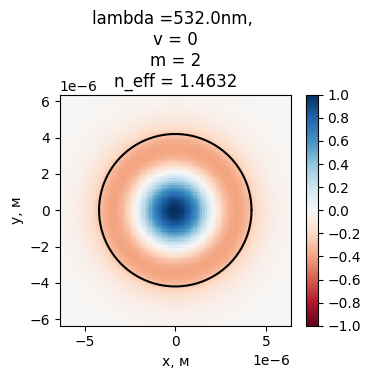

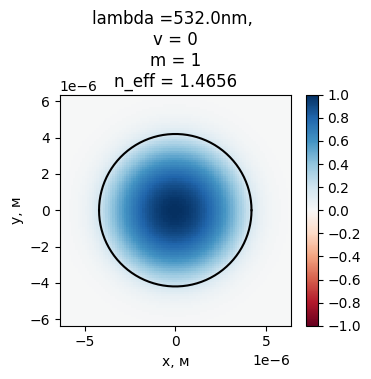

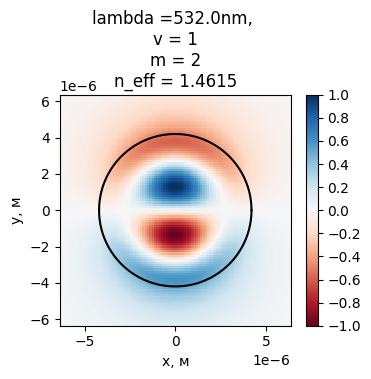

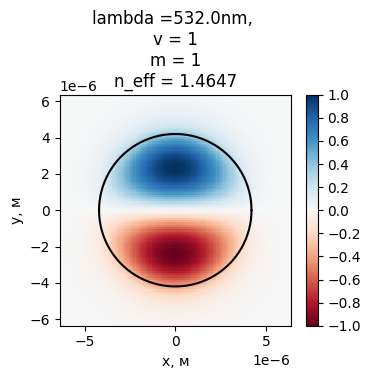

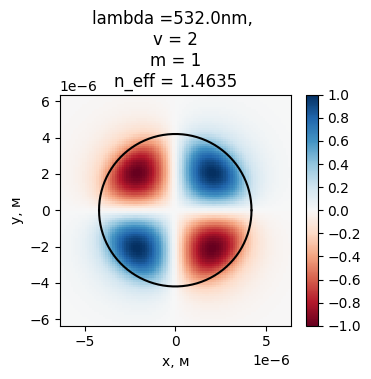

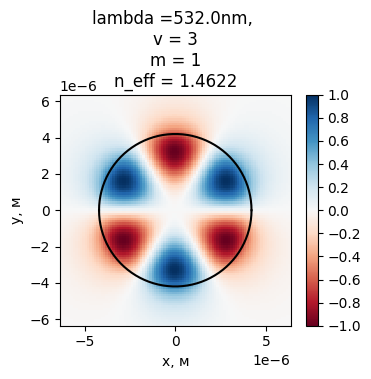

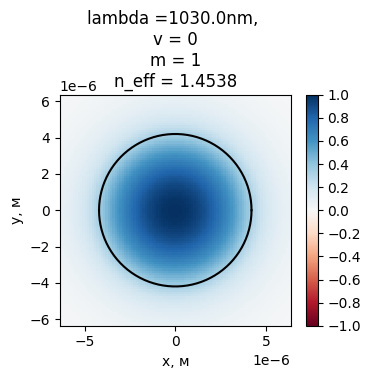

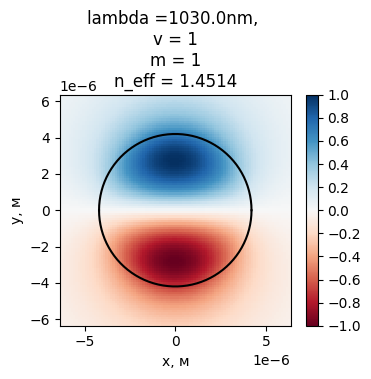

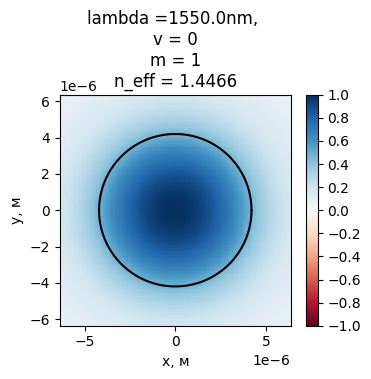

In [4]:
r_core = 4.2e-6
lmbdas = np.array([.532e-6, 1.03e-6, 1.55e-6])
delta_n = 5.5e-3
vs = [0, 1, 2, 3, 4, 5]
# vs = [0, 1, 2, 3]
# vs = [0]

values = []

for lmbda in lmbdas:
    k0 = 2 * pi / lmbda
    n_clad = np.sqrt(1 + 0.696166300*(1e6*lmbda)**2/((1e6*lmbda)**2 - 4.67914826*10**(-3)) + 0.407942600*(1e6*lmbda)**2/((1e6*lmbda)**2 - 1.35120631*10**(-2)) + 0.897479400*(1e6*lmbda)**2/((1e6*lmbda)**2 - 97.9340025))
    n_core = n_clad + delta_n
    for v in vs:


        result = multi_root(function_for_neff, args= (n_clad, n_core, r_core, k0, v), bracket=[n_clad + 1e-8, n_core - 1e-8], n = 100)
        # print("-------result (zeroes of det : n_eff):", result)
        
        # fig, ax = plt.subplots(figsize = (8, 6))
        # n_eff = np.linspace(n_clad, n_core +3.0e-3, 1000)
        # plt.plot(n_eff, function_for_neff(n_eff, n_clad, n_core , r_core, k0, v))
        # plt.plot([n_clad, n_core+1.0e-3], [0, 0], 'r-', linewidth = 0.2)
        # plt.ylim(-1, 1)
        # plt.title(f'det (find root), v = {v}')
        # plt.plot(result, result*0, 'bo')

        v = v # порядок функции Бесселя

        for i in range(0, len(result)):
            n_eff = result[i]
            m = len(result) - i #second index of mode
            values.append([n_eff, v, m, lmbda])

            
            #plot everything
            x = np.linspace(-1.5*r_core, 1.5*r_core, 100)
            y = np.linspace(-1.5*r_core, 1.5*r_core, 100)
            X, Y = np.meshgrid(x, y)
            Z = func(X, Y, v, r_core, k0, n_core, n_clad, n_eff)


            fig, ax = plt.subplots(figsize = (4, 3))
            ax.set_aspect(1)

            #plot mode
            vmin = -1
            vmax = 1
            norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

            plt.pcolor(X, Y, Z, norm=norm, cmap='RdBu')   
            plt.colorbar(ticks=[-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

            razmer = 10
            plt.xlabel("x, м", size = razmer)
            plt.ylabel("y, м", size = razmer)

            plt.rc('xtick', labelsize= razmer) 
            plt.rc('ytick', labelsize= razmer ) 

            plt.title('lambda =' + str(lmbda * 10**9) + 'nm, \nv = ' + str(v) + '\nm = ' + str(m) + '\nn_eff = '+ "{:6.4f}".format(n_eff))

            #plot r_core circle on top
            r = r_core
            phi = np.linspace(0, np.pi)
            plt.plot(r_core*np.cos(phi), r_core * np.sin(phi), color = 'black')
            plt.plot(r_core*np.cos(phi), -r_core * np.sin(phi), color = 'black')

            


print(values)
    #plt.savefig('мода LP32 интенсивность')

In [5]:
df_val = pd.DataFrame(values)
df_val.columns =['n_eff', 'v', 'm', 'lmbda']
df_sorted = df_val.sort_values(by = 'n_eff')
df_sorted

,n_eff,v,m,lmbda
8,1.446567,0,1,1.550000e-06
7,1.451430,1,1,1.030000e-06
6,1.453828,0,1,1.030000e-06
2,1.461477,1,2,5.320000e-07
5,1.462155,3,1,5.320000e-07
0,1.463167,0,2,5.320000e-07
4,1.463546,2,1,5.320000e-07
3,1.464711,1,1,5.320000e-07
1,1.465613,0,1,5.320000e-07


In [25]:
#длина волны отсечки - только одна распространяемая мода (фундаментальная) 
# lmbdas = np.linspace(1030e-9, 20000e-9, 100)
#strating with lower lambdas , len >= 1 = there is LP01, len = 0 -отсечка
def find_switch(lmbdas, v, m, err = 0.001):
    for i, lmbda in enumerate(lmbdas):
        k0 = 2 * pi / lmbda
        n_clad = np.sqrt(1 + 0.696166300*(1e6*lmbda)**2/((1e6*lmbda)**2 - 4.67914826*10**(-3)) + 0.407942600*(1e6*lmbda)**2/((1e6*lmbda)**2 - 1.35120631*10**(-2)) + 0.897479400*(1e6*lmbda)**2/((1e6*lmbda)**2 - 97.9340025))
        n_core = n_clad + delta_n
        result = multi_root(function_for_neff, args= (n_clad, n_core, r_core, k0, v), bracket=[n_clad + 1e-8, n_core - 1e-8], n = 20)
        # print(lmbda * 1e9, result)
        if len(result) < m:
            # print(i, f'LP{v}{m} switches between  {lmbdas[i - 1] * 1e9 } and {lmbda * 1e9}')
            break

    if(abs(lmbdas[i - 1] - lmbda) <= err*1e-9):
        print(f'LP{v}{m} не существуте при длине волны больше {lmbda * 1e9} нм')   
        return lmbda   
    
    elif(abs(lmbdas[i - 1] - lmbda) > err*1e-9):
        lmbdas2 = np.linspace(lmbdas[i - 1], lmbda, 100)
        return find_switch(lmbdas2, v, m)
        


In [26]:
lmbdas = np.linspace(100e-9, 10000e-9, 100)
y = find_switch(lmbdas, 0, 1)


LP01 не существуте при длине волны больше 6061.296672469002 нм


In [22]:
lmbdas = np.linspace(100e-9, 2000e-9, 10)
l02  = find_switch(lmbdas, 0, 2)
l11  = find_switch(lmbdas, 1, 1)
print(f"длина волны отсечки: {max(l02, l11)* 1e9} нм")

LP02 не существуте при длине волны больше 860.482925595329 нм
LP11 не существуте при длине волны больше 1385.243071122063 нм
длина волны отсечки: 1385.243071122063 нм


In [24]:
lmbdas = np.linspace(532e-9, 1030e-9, 10)
y  = find_switch(lmbdas, 2, 1)


LP21 не существуте при длине волны больше 871.2698140813641 нм
